# 3.4 ブラックレベル補正

## この節について

この節では、ブラックレベル補正を行い画像の明るさと色を修正します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_3_4.ipynb

## 準備

まず3.1節で行ったライブラリーのインストールと、モジュールのインポート、画像のダウンロード、及びRAW画像の読み込みを行います。
内容については各節を参照ください。

In [9]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then wget https://raw.githubusercontent.com/moizumi99/camera_raw_process/master/raw_process.py; fi

from raw_process import simple_demosaic, white_balance

# 画像をダウンロードします。
!if [ ! -f sample.ARW ]; then wget https://raw.githubusercontent.com/moizumi99/camera_raw_process/master/sample.ARW; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "sample.ARW"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_array = raw_array.reshape((h, w));

## ブラックレベル補正とは

RAWデータの黒に対応する値は通常０より大きくなっています。

これは、センサーの読み出しノイズがマイナスの値を取ることがあるために、画像の値を０以上にしてしまうと、ノイズのクリッピングがおきて非常に暗い領域で色ズレがおきてしまうためです。

したがって、正しい画像処理を行うにはブラックレベルを調整して置かなくてはなりません。これをやって置かないと黒が十分黒くない、カスミがかかったような眠い画像になってしまいますし、色もずれてしまいます。

## ブラックレベル補正処理

ますはどんなブラックレベル値かみてみましょう。

まず、rawpyのアトリビュートを使ってブラックレベルを確認しましょう。

In [2]:
blc = raw.black_level_per_channel
print(blc)

[512, 512, 512, 512]


これは全チャンネルでブラックレベルは512であるという事をしめしています。

今回は全チャンネルで同じ値でしたが、他のRAWファイルでもこのようになっているとは限りません。各画素ごとのチャンネルに対応した値を引くようにしておきましょう。


In [3]:
# ベイヤー配列パターンを変数に保存
bayer_pattern = raw.raw_pattern

# RAWデータを符号付き整数としてコピー。
blc_raw = raw_array.astype('int')
# 各画素毎に対応するブラックレベルを参照して引いていく。
for y in range(0, h, 2):
    for x in range(0, w, 2):
        blc_raw[y + 0, x + 0] -= blc[bayer_pattern[0, 0]]
        blc_raw[y + 0, x + 1] -= blc[bayer_pattern[0, 1]]
        blc_raw[y + 1, x + 0] -= blc[bayer_pattern[1, 0]]
        blc_raw[y + 1, x + 1] -= blc[bayer_pattern[1, 1]]

処理が正常に行われたか、最大値と最小値を比較しておきましょう。

In [4]:
print("ブラックレベル補正前: 最小値=", raw_array.min(), ", 最大値=", raw_array.max())
print("ブラックレベル補正前: 最小値=", blc_raw.min(), ", 最大値=", blc_raw.max())

ブラックレベル補正前: 最小値= 0 , 最大値= 8180
ブラックレベル補正前: 最小値= -512 , 最大値= 7668


どうやら正常に処理が行われたようです。

## ブラックレベル後の画像の確認

ホワイトバランスと簡易デモザイク処理を行って、ブラックレベルが正常に補正されたか確認しましょう。

In [5]:
# 最初に定義したwhite_balance()関数を使って、ホワイトバランス調整。
wb_img = white_balance(blc_raw, raw.camera_whitebalance, raw.raw_colors)
# simple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

では、処理の結果を見てみましょう。

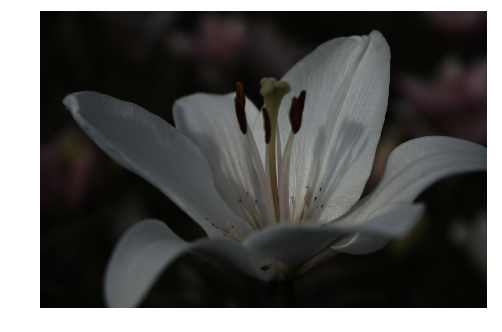

In [6]:
# 表示
plt.figure(figsize=(8, 8))
# imshowでは画像は0から1.0の値をとる必用があるので、ノーマライズする。
dms_img[dms_img<0] = 0
dms_img /= dms_img.max()
imshow(dms_img)
plt.axis('off')
plt.show()

だいぶきれいになりました。
前回問題だった赤みがかった色も集成されています。

ただし、だいぶ暗い画像になっています。これはガンマ補正がされていないためです。次はガンマ補正をかけてみましょう。

## 処理の高速化

今回のブラックレベル補正処理もコードの読みやすさを優先して、非常に遅いものになっています。

numpyの機能を利用して高速化すると次のようになります。

In [7]:
def black_level_correction(raw_array, blc, bayer_pattern):
    """ 
    ブラックレベル補正処理を行う。
    
    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ。
    blc: float[4]
        各カラーチャンネルごとのブラックレベル。
    bayer_pattern: int[2, 2]
        ベイヤーパターン。0:赤、1:緑、2:青、3:緑。
        
    Returns
    -------
    blc_raw: numpy array
        出力RAW画像。
    """    
    # 符号付き整数として入力画像をコピー
    blc_raw = raw_array.astype('int')
    # 各カラーチャンネル毎にブラックレベルを引く。
    blc_raw[0::2, 0::2] -= blc[bayer_pattern[0, 0]]
    blc_raw[0::2, 1::2] -= blc[bayer_pattern[0, 1]]
    blc_raw[1::2, 0::2] -= blc[bayer_pattern[1, 0]]
    blc_raw[1::2, 1::2] -= blc[bayer_pattern[1, 1]]
    return blc_raw

簡易デモザイク処理を行って確認しましょう。

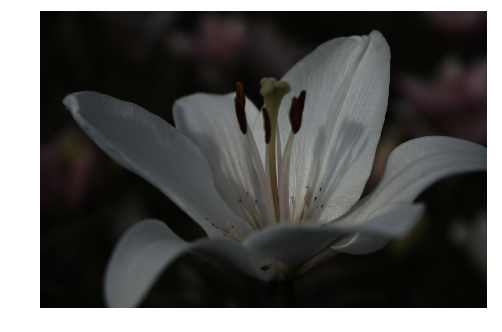

In [8]:
# 上記のblack_level_correction関数を使用してブラックレベル補正。
blc_raw = black_level_correction(raw_array, blc, raw.raw_pattern)
# 最初に定義したwhite_balance()関数を使って、ホワイトバランス調整。
wb_img = white_balance(blc_raw, raw.camera_whitebalance, raw.raw_colors)
# simple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

# 表示
plt.figure(figsize=(8, 8))
# imshowでは画像は0から1.0の値をとる必用があるので、ノーマライズする。
dms_img[dms_img<0] = 0
dms_img /= dms_img.max()
imshow(dms_img)
plt.axis('off')
plt.show()

同様の画像が出力されたようです。

この`black_level_correction()`関数は`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py`

としてダウンロードした後、

`from raw_process import black_level_correction`

としてインポートしてください。

## まとめ

この節ではブラックレベル補正を行いました。次は[ガンマ補正](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_3_5.ipynb)を行い、明るさとトーンを補正します。